# LSTM
Long Short-Term Memory

In [7]:
import glob
import os
from pathlib import Path
from scipy.io import wavfile

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
# Dataset
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import CrossEntropyLoss, LogSoftmax


import librosa
import librosa.display
import IPython.display as ipd

from tqdm.notebook import tqdm
# from google_drive_downloader import GoogleDriveDownloader as gdd

## AudioDataset Class

In [8]:
sliced_dataset = "short_audio_dataset"
sliced_dataset_lenght = 16050
# sliced_dataset = "shorter_audio_dataset"
# sliced_dataset_lenght = 4013
original_dataset = "audio_dataset"
original_dataset_lenght = 80249

class AudioDataset(Dataset):
    def __init__(self, root_path="./data/", drop_both=False, use_short=False, active='wavs', normalize=False):
        root_folder = root_path + original_dataset if not use_short else root_path + sliced_dataset
        self.max_length = original_dataset_lenght if not use_short else sliced_dataset_lenght
        self.class_map = {"esben" : 0, "peter": 1, "both": 2}
        self.data = []
        self.labels = []
        self.min_val = 10e10
        self.max_val = 0
        self.normalize = normalize
        self.wavs, self.mfccs, self.chromas, self.contrasts, self.centroids, self.bandwidths = [], [], [], [], [], []
        self.wavs_norm, self.mfccs_norm, self.chromas_norm, self.contrasts_norm, self.centroids_norm, self.bandwidths_norm = [], [], [], [], [], []
        
        print("Start reading files and genearting features")
        for subdir, dirs, files in os.walk(root_folder):
            for file_name in files:
                if drop_both and "both" in subdir:
                   continue
        
                file_path = os.path.join(subdir, file_name)
                self.sample_rate, wav = wavfile.read(file_path)
                wav = wav.astype(np.float32)
                
                if wav.shape[0] > self.max_length:
                    self.max_length = wav.shape[0]
                    print("Found wav with more length than specified max one, new max is:", wav.shape[0])
                
                self.feature_extraction(wav, self.sample_rate)
                wav = np.pad(wav, (0, self.max_length-wav.shape[0]))
                label_str = file_path.split('/')[-3][2:]
                label = (np.int64(self.class_map[label_str]))
                
                self.max_val = np.max(wav) if np.max(wav) > self.max_val else self.max_val
                self.min_val = np.min(wav) if np.min(wav) < self.min_val else self.min_val
                
                self.wavs.append(wav)
                self.labels.append(label)
               
        self.wavs = np.array(self.wavs)
        self.mu  = self.wavs.mean()
        self.std = np.std(self.wavs)
        # self.wavs = torch.Tensor(self.wavs)

        self.active = active
        self.values_dict = {'wavs': 0, 'mfcc': 1, 'chroma': 2, 'contrast': 3, 'centroid': 4, 'bandwidth': 5}
        self.values_list = [self.wavs, self.mfccs, self.chromas, self.contrasts, self.centroids, self.bandwidths]
        self.values_norm_list = []
        print("Generating normalized arrays")
        for lst in self.values_list:
            self.values_norm_list.append((lst + np.abs(np.min(lst))) / (np.abs(np.min(lst)) + np.max(lst)))
            
        print("="*40)
        print("Loaded DATABASE from {}\n{} total file\nLongest file is {} long\nMean: {}\nStandard deviation: {}\n".
              format(root_folder, len(self.wavs), self.max_length, self.mu, self.std))
        print("="*40)

    def feature_extraction(self, wav, sample_rate):
        self.mfccs.append(np.transpose(np.mean(librosa.feature.mfcc(y=wav, sr=sample_rate, n_mfcc=128).T, axis=0)))
        # self.chromas.append(np.transpose(np.mean(librosa.feature.chroma_cqt(y=wav, sr=sample_rate).T, axis=0)))
        self.chromas.append(np.transpose(np.mean(librosa.feature.chroma_stft(y=wav, sr=sample_rate).T, axis=0)))
        self.contrasts.append(np.transpose(np.mean(librosa.feature.spectral_contrast(y=wav, sr=sample_rate).T, axis=0)))
        self.centroids.append(np.transpose(np.mean(librosa.feature.spectral_centroid(y=wav, sr=sample_rate).T, axis=0)))
        self.bandwidths.append(np.transpose(np.mean(librosa.feature.spectral_bandwidth(y=wav, sr=sample_rate).T, axis=0)))

    def __len__(self):
        return len(self.wavs)
    
    def __getitem__(self, idx):
        y = self.labels[idx]
        x = self.values_list[self.values_dict[self.active]][idx]
        if self.normalize:
            x = self.values_norm_list[self.values_dict[self.active]][idx]
        x = torch.Tensor(x)
        return x, y


Data Generation

In [9]:
# Load data

batch_size = 15
drop_both = False
if drop_both == False:
    num_classes = 3
else: 
    num_classes = 2
audio_dataset = AudioDataset(root_path="../data/", drop_both=drop_both, use_short=False)
dataset_len = len(audio_dataset)
train_size, test_size, valid_size = round(dataset_len * 0.7), round(dataset_len * 0.2), round(dataset_len * 0.1)

dataset_train, dataset_test, dataset_valid = torch.utils.data.random_split(audio_dataset, (train_size, test_size, valid_size))

kwargs = {'batch_size': batch_size, 'num_workers': 1}
loader_train = torch.utils.data.DataLoader(dataset_train, **kwargs, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, **kwargs, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, **kwargs, shuffle=True)

# 33% should be considered like with the other methods 
# In the solution he plots the lengths of the data...but thats just for educational purpose so I didn't reuse that

Start reading files and genearting features
Generating normalized arrays
Loaded DATABASE from ../data/audio_dataset
300 total file
Longest file is 80249 long
Mean: -0.5514468550682068
Standard deviation: 2504.506103515625



In [10]:
class voiceClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(voiceClassifier, self).__init__()  
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers) # Long Short Term Memory Layer -> 
        self.fc = nn.Linear(hidden_size, output_size)
        # self.sigmoid = nn.Sigmoid()  # Could only be used when both was not used - binary classification

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(x.device) # initial hiddens
        c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(x.device) # initial cell states
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # Output shape: (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out)
        # output = self.sigmoid(out)  # Sigmoid for binary classification
        #output = F.softmax(out[:, -1, :], dim=1)  # Softmax for multi-class classification
        output = F.softmax(out, dim=1)  # Softmax for multi-class classification

        return output


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 1.0986, Train Acc: 0.3571, Valid Loss: 1.0986, Valid Acc: 0.3667
Epoch [2/50], Train Loss: 1.0986, Train Acc: 0.3714, Valid Loss: 1.0986, Valid Acc: 0.2333
Epoch [3/50], Train Loss: 1.0986, Train Acc: 0.3524, Valid Loss: 1.0986, Valid Acc: 0.3333
Epoch [4/50], Train Loss: 1.0986, Train Acc: 0.3238, Valid Loss: 1.0986, Valid Acc: 0.4000
Epoch [5/50], Train Loss: 1.0986, Train Acc: 0.3905, Valid Loss: 1.0986, Valid Acc: 0.3667
Epoch [6/50], Train Loss: 1.0986, Train Acc: 0.3619, Valid Loss: 1.0986, Valid Acc: 0.3667
Epoch [7/50], Train Loss: 1.0986, Train Acc: 0.3143, Valid Loss: 1.0986, Valid Acc: 0.3333
Epoch [8/50], Train Loss: 1.0986, Train Acc: 0.3714, Valid Loss: 1.0986, Valid Acc: 0.5000
Epoch [9/50], Train Loss: 1.0986, Train Acc: 0.3381, Valid Loss: 1.0986, Valid Acc: 0.3333
Epoch [10/50], Train Loss: 1.0986, Train Acc: 0.3143, Valid Loss: 1.0986, Valid Acc: 0.3333
Epoch [11/50], Train Loss: 1.0986, Train Acc: 0.3143, Valid Loss: 1.0986, Valid Acc: 0.33

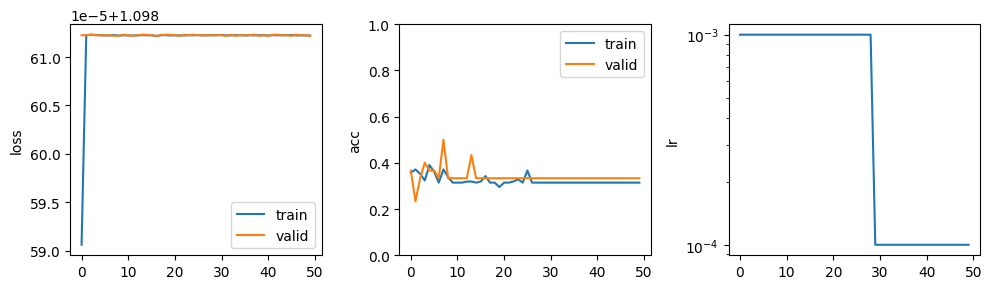

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 1.0986, Train Acc: 0.5143, Valid Loss: 1.0985, Valid Acc: 0.6000
Epoch [2/50], Train Loss: 1.0984, Train Acc: 0.5762, Valid Loss: 1.0983, Valid Acc: 0.5000
Epoch [3/50], Train Loss: 1.0981, Train Acc: 0.5952, Valid Loss: 1.0981, Valid Acc: 0.4667
Epoch [4/50], Train Loss: 1.0975, Train Acc: 0.6524, Valid Loss: 1.0973, Valid Acc: 0.5333
Epoch [5/50], Train Loss: 1.0966, Train Acc: 0.6048, Valid Loss: 1.0962, Valid Acc: 0.5333
Epoch [6/50], Train Loss: 1.0951, Train Acc: 0.6000, Valid Loss: 1.0947, Valid Acc: 0.4667
Epoch [7/50], Train Loss: 1.0923, Train Acc: 0.6143, Valid Loss: 1.0917, Valid Acc: 0.6000
Epoch [8/50], Train Loss: 1.0884, Train Acc: 0.6333, Valid Loss: 1.0900, Valid Acc: 0.5000
Epoch [9/50], Train Loss: 1.0842, Train Acc: 0.6286, Valid Loss: 1.0831, Valid Acc: 0.5000
Epoch [10/50], Train Loss: 1.0771, Train Acc: 0.6429, Valid Loss: 1.0768, Valid Acc: 0.5333
Epoch [11/50], Train Loss: 1.0690, Train Acc: 0.6143, Valid Loss: 1.0709, Valid Acc: 0.56

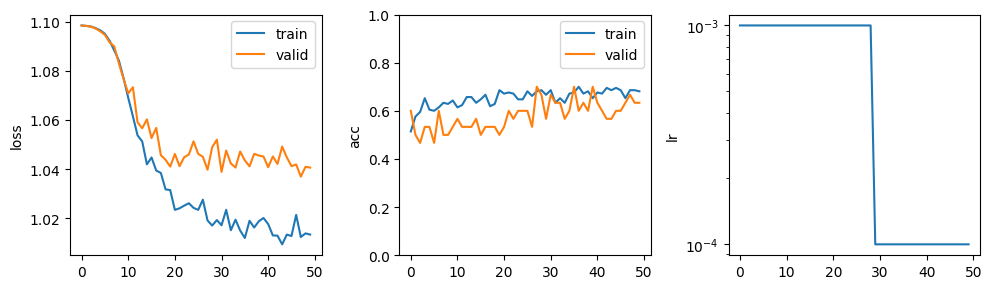

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 1.0985, Train Acc: 0.4333, Valid Loss: 1.0981, Valid Acc: 0.5000
Epoch [2/50], Train Loss: 1.0982, Train Acc: 0.4714, Valid Loss: 1.0975, Valid Acc: 0.5667
Epoch [3/50], Train Loss: 1.0974, Train Acc: 0.4810, Valid Loss: 1.0955, Valid Acc: 0.6000
Epoch [4/50], Train Loss: 1.0958, Train Acc: 0.4952, Valid Loss: 1.0924, Valid Acc: 0.6000
Epoch [5/50], Train Loss: 1.0936, Train Acc: 0.4810, Valid Loss: 1.0882, Valid Acc: 0.5333
Epoch [6/50], Train Loss: 1.0893, Train Acc: 0.4714, Valid Loss: 1.0801, Valid Acc: 0.5667
Epoch [7/50], Train Loss: 1.0834, Train Acc: 0.4810, Valid Loss: 1.0700, Valid Acc: 0.5667
Epoch [8/50], Train Loss: 1.0800, Train Acc: 0.4381, Valid Loss: 1.0626, Valid Acc: 0.5333
Epoch [9/50], Train Loss: 1.0754, Train Acc: 0.4619, Valid Loss: 1.0614, Valid Acc: 0.6000
Epoch [10/50], Train Loss: 1.0725, Train Acc: 0.4429, Valid Loss: 1.0532, Valid Acc: 0.6000
Epoch [11/50], Train Loss: 1.0694, Train Acc: 0.4476, Valid Loss: 1.0547, Valid Acc: 0.53

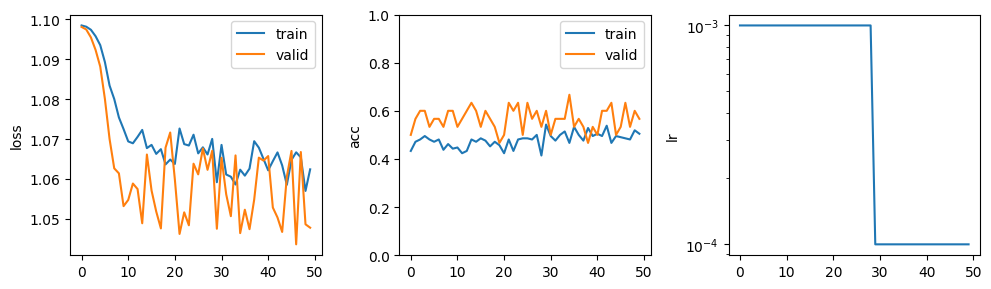

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 1.0986, Train Acc: 0.4762, Valid Loss: 1.0985, Valid Acc: 0.4333
Epoch [2/50], Train Loss: 1.0985, Train Acc: 0.4619, Valid Loss: 1.0983, Valid Acc: 0.5000
Epoch [3/50], Train Loss: 1.0983, Train Acc: 0.4905, Valid Loss: 1.0980, Valid Acc: 0.5667
Epoch [4/50], Train Loss: 1.0980, Train Acc: 0.4571, Valid Loss: 1.0975, Valid Acc: 0.5000
Epoch [5/50], Train Loss: 1.0973, Train Acc: 0.4714, Valid Loss: 1.0962, Valid Acc: 0.5000
Epoch [6/50], Train Loss: 1.0963, Train Acc: 0.4905, Valid Loss: 1.0948, Valid Acc: 0.5667
Epoch [7/50], Train Loss: 1.0950, Train Acc: 0.4667, Valid Loss: 1.0922, Valid Acc: 0.5667
Epoch [8/50], Train Loss: 1.0923, Train Acc: 0.4857, Valid Loss: 1.0892, Valid Acc: 0.5667
Epoch [9/50], Train Loss: 1.0894, Train Acc: 0.4810, Valid Loss: 1.0849, Valid Acc: 0.5000
Epoch [10/50], Train Loss: 1.0878, Train Acc: 0.4762, Valid Loss: 1.0801, Valid Acc: 0.6000
Epoch [11/50], Train Loss: 1.0840, Train Acc: 0.4762, Valid Loss: 1.0775, Valid Acc: 0.56

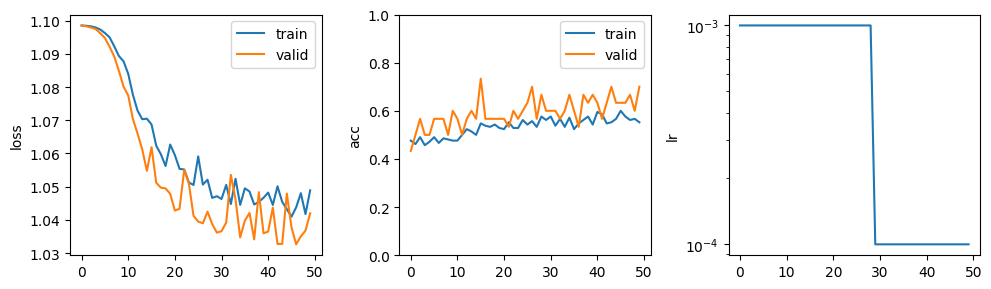

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 1.0981, Train Acc: 0.3333, Valid Loss: 1.1016, Valid Acc: 0.3000
Epoch [2/50], Train Loss: 1.0930, Train Acc: 0.5286, Valid Loss: 1.1005, Valid Acc: 0.3000
Epoch [3/50], Train Loss: 1.0890, Train Acc: 0.6286, Valid Loss: 1.1008, Valid Acc: 0.3000
Epoch [4/50], Train Loss: 1.0837, Train Acc: 0.7238, Valid Loss: 1.0994, Valid Acc: 0.2667
Epoch [5/50], Train Loss: 1.0811, Train Acc: 0.7048, Valid Loss: 1.0999, Valid Acc: 0.3000
Epoch [6/50], Train Loss: 1.0756, Train Acc: 0.7619, Valid Loss: 1.0994, Valid Acc: 0.3333
Epoch [7/50], Train Loss: 1.0707, Train Acc: 0.7619, Valid Loss: 1.1004, Valid Acc: 0.2667
Epoch [8/50], Train Loss: 1.0679, Train Acc: 0.7714, Valid Loss: 1.1005, Valid Acc: 0.3333
Epoch [9/50], Train Loss: 1.0608, Train Acc: 0.8286, Valid Loss: 1.0990, Valid Acc: 0.3333
Epoch [10/50], Train Loss: 1.0572, Train Acc: 0.8095, Valid Loss: 1.0993, Valid Acc: 0.3333
Epoch [11/50], Train Loss: 1.0545, Train Acc: 0.7857, Valid Loss: 1.0984, Valid Acc: 0.33

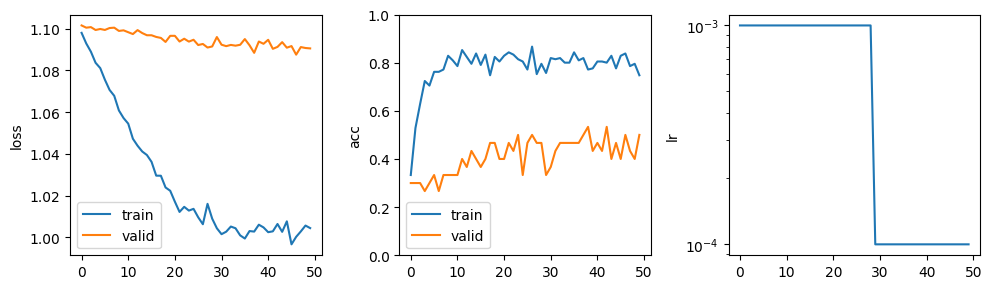

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 1.0950, Train Acc: 0.5143, Valid Loss: 1.0902, Valid Acc: 0.6000
Epoch [2/50], Train Loss: 1.0781, Train Acc: 0.6476, Valid Loss: 1.0778, Valid Acc: 0.4667
Epoch [3/50], Train Loss: 1.0583, Train Acc: 0.6857, Valid Loss: 1.0549, Valid Acc: 0.6000
Epoch [4/50], Train Loss: 1.0419, Train Acc: 0.7000, Valid Loss: 1.0466, Valid Acc: 0.5333
Epoch [5/50], Train Loss: 1.0253, Train Acc: 0.7429, Valid Loss: 1.0289, Valid Acc: 0.7333
Epoch [6/50], Train Loss: 1.0212, Train Acc: 0.7476, Valid Loss: 1.0350, Valid Acc: 0.6667
Epoch [7/50], Train Loss: 1.0178, Train Acc: 0.7286, Valid Loss: 1.0211, Valid Acc: 0.8000
Epoch [8/50], Train Loss: 1.0078, Train Acc: 0.7571, Valid Loss: 1.0135, Valid Acc: 0.7000
Epoch [9/50], Train Loss: 1.0060, Train Acc: 0.7238, Valid Loss: 1.0093, Valid Acc: 0.7000
Epoch [10/50], Train Loss: 0.9956, Train Acc: 0.7810, Valid Loss: 1.0001, Valid Acc: 0.8000
Epoch [11/50], Train Loss: 1.0006, Train Acc: 0.7524, Valid Loss: 0.9984, Valid Acc: 0.80

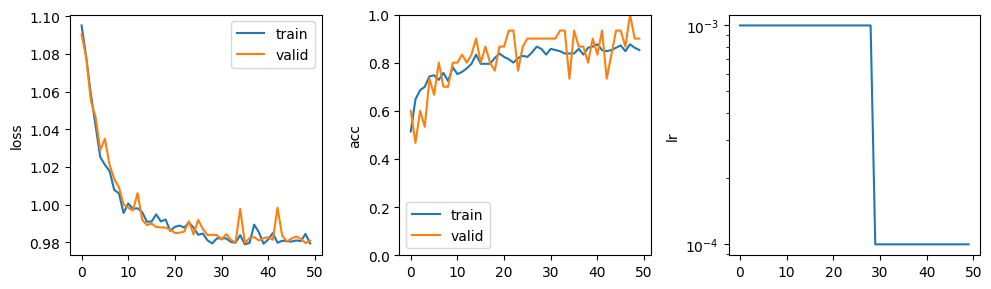

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 1.0985, Train Acc: 0.4619, Valid Loss: 1.0982, Valid Acc: 0.5667
Epoch [2/50], Train Loss: 1.0982, Train Acc: 0.4952, Valid Loss: 1.0976, Valid Acc: 0.5667
Epoch [3/50], Train Loss: 1.0977, Train Acc: 0.4524, Valid Loss: 1.0963, Valid Acc: 0.5667
Epoch [4/50], Train Loss: 1.0969, Train Acc: 0.4619, Valid Loss: 1.0946, Valid Acc: 0.5333
Epoch [5/50], Train Loss: 1.0953, Train Acc: 0.4905, Valid Loss: 1.0911, Valid Acc: 0.5333
Epoch [6/50], Train Loss: 1.0929, Train Acc: 0.4571, Valid Loss: 1.0871, Valid Acc: 0.5333
Epoch [7/50], Train Loss: 1.0887, Train Acc: 0.4476, Valid Loss: 1.0812, Valid Acc: 0.5333
Epoch [8/50], Train Loss: 1.0828, Train Acc: 0.4667, Valid Loss: 1.0679, Valid Acc: 0.5333
Epoch [9/50], Train Loss: 1.0796, Train Acc: 0.4571, Valid Loss: 1.0643, Valid Acc: 0.6000
Epoch [10/50], Train Loss: 1.0723, Train Acc: 0.4524, Valid Loss: 1.0648, Valid Acc: 0.5667
Epoch [11/50], Train Loss: 1.0654, Train Acc: 0.4667, Valid Loss: 1.0578, Valid Acc: 0.53

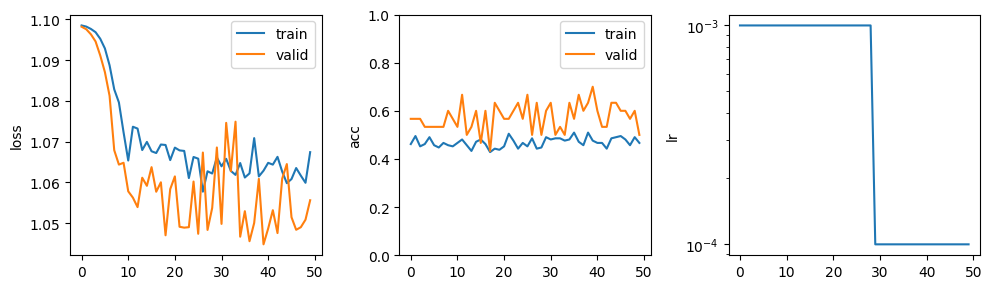

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 1.0967, Train Acc: 0.4714, Valid Loss: 1.0929, Valid Acc: 0.5667
Epoch [2/50], Train Loss: 1.0906, Train Acc: 0.5095, Valid Loss: 1.0823, Valid Acc: 0.5000
Epoch [3/50], Train Loss: 1.0769, Train Acc: 0.5286, Valid Loss: 1.0618, Valid Acc: 0.5000
Epoch [4/50], Train Loss: 1.0643, Train Acc: 0.4952, Valid Loss: 1.0499, Valid Acc: 0.5000
Epoch [5/50], Train Loss: 1.0544, Train Acc: 0.5000, Valid Loss: 1.0453, Valid Acc: 0.4333
Epoch [6/50], Train Loss: 1.0407, Train Acc: 0.5714, Valid Loss: 1.0491, Valid Acc: 0.5000
Epoch [7/50], Train Loss: 1.0388, Train Acc: 0.5571, Valid Loss: 1.0360, Valid Acc: 0.4667
Epoch [8/50], Train Loss: 1.0426, Train Acc: 0.5429, Valid Loss: 1.0424, Valid Acc: 0.6333
Epoch [9/50], Train Loss: 1.0387, Train Acc: 0.5333, Valid Loss: 1.0377, Valid Acc: 0.5333
Epoch [10/50], Train Loss: 1.0376, Train Acc: 0.5714, Valid Loss: 1.0244, Valid Acc: 0.5667
Epoch [11/50], Train Loss: 1.0405, Train Acc: 0.5524, Valid Loss: 1.0243, Valid Acc: 0.46

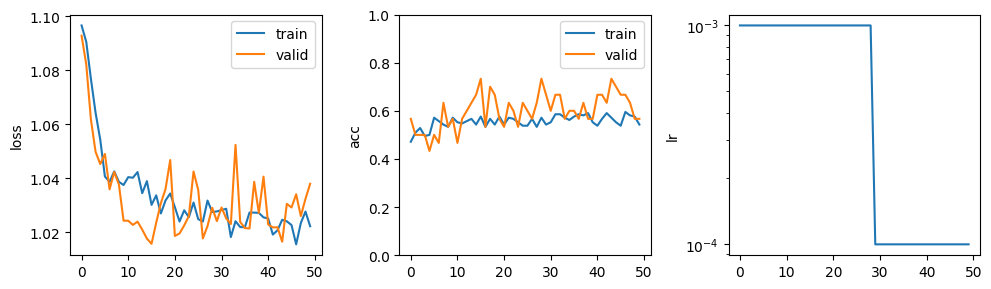

In [11]:
num_layers = 1  # Number of LSTM layers

device = torch.device('cuda')
with open('../data/lstm.txt', "w") as f:
  for norm in (True, False):
    audio_dataset.normalize = norm
    for feature in ('wavs', 'mfcc', 'chroma', 'contrast'):  
        audio_dataset.active = feature
        for n_hidden_neurons in ([500]):
            model = voiceClassifier(int(audio_dataset[0][0].shape[0]), n_hidden_neurons, num_layers, num_classes)
            #opt = torch.optim.SGD(model.parameters(), lr=5e-2)
            opt = torch.optim.Adam(model.parameters(), lr=1e-3)
            sched = torch.optim.lr_scheduler.MultiStepLR(opt, (30,))
            train_losses, train_accuracies = [], []
            valid_losses, valid_accuracies = [], []
            lrs = []
    
            for epoch in tqdm(range(50)):
                # Train
                model.train()
                losses=[]
                #train_losses = []
                train_correct = 0
                train_total = 0
                for x, y in loader_train:
                    opt.zero_grad()
                    x = x.unsqueeze(0)
                    logits = model(x)
                    logits = logits.squeeze()

                    # make target out of vector
                    one_hot_targets = torch.zeros(batch_size, num_classes) # empty tensor to hold the one-hot encoded targets
                    for idx, target in enumerate(y): # Fill one-hot encoded values based on the target values
                        one_hot_targets[idx, target] = 1
                    loss_func = nn.CrossEntropyLoss()  # Define the loss function
                    
                    #print("targets: ", one_hot_targets)
                    loss = loss_func(logits, one_hot_targets)  # Calculate the loss directly
                
                    # Backpropagation and parameter updates
                    loss.backward()
                    opt.step()
                    losses.append(loss.item())
                    train_total += y.size(0)
                    train_correct += (torch.argmax(logits, dim=1) == y.view(-1)).sum().item()
                    
                avg_train_loss = np.mean(losses) #added from old
                train_accuracy = train_correct / train_total

                # History - Saved for plotting 
                train_losses.append(avg_train_loss)
                train_accuracies.append(train_accuracy)
                
                # Validation
                model.eval()
                losses = []
                valid_correct = 0
                valid_total = 0
                
                for x, y in loader_valid:
                    x = x.unsqueeze(0)  # Add a batch dimension assuming it's a single sequence
                    with torch.no_grad():
                        logits = model(x)
                    logits = logits.squeeze()
                    one_hot_targets = torch.zeros(batch_size, num_classes) # empty tensor to hold the one-hot encoded targets
                    for idx, target in enumerate(y): # Fill one-hot encoded values based on the target values
                        one_hot_targets[idx, target] = 1
            
                    loss_func = nn.CrossEntropyLoss()  # Define the loss function
                    loss = loss_func(logits, one_hot_targets)  # Calculate the loss directly
            
                    losses.append(loss.item())
                    valid_total += y.size(0)
                    valid_correct += (torch.argmax(logits, dim=1) == y.view(-1)).sum().item()
            
                        
                avg_valid_loss = np.mean(losses) # added from old
                valid_accuracy = valid_correct / valid_total
                #avg_valid_loss = sum(losses) / len(losses)
                
               
                
                valid_losses.append(avg_valid_loss)
                valid_accuracies.append(valid_accuracy)
                
                print(f"Epoch [{epoch + 1}/50], "
                      f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
                      f"Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}")

                # Validation
                model.eval()
                losses = []
                test_correct = 0
                test_total = 0
                
                for x, y in loader_test:
                    x = x.unsqueeze(0)  # Add a batch dimension assuming it's a single sequence
                    with torch.no_grad():
                        logits = model(x)
                    logits = logits.squeeze()
                    #one_hot_targets = torch.zeros(batch_size, num_classes) # empty tensor to hold the one-hot encoded targets
                    #for idx, target in enumerate(y): # Fill one-hot encoded values based on the target values
                    #    one_hot_targets[idx, target] = 1
            
                    #loss_func = nn.CrossEntropyLoss()  # Define the loss function
                    #loss = loss_func(logits, one_hot_targets)  # Calculate the loss directly
            
                    #losses.append(loss.item())
                    test_total += y.size(0)
                    test_correct += (torch.argmax(logits, dim=1) == y.view(-1)).sum().item()
            
                        
                #avg_valid_loss = np.mean(losses) # added from old
                test_accuracy = valid_correct / valid_total
                #avg_valid_loss = sum(losses) / len(losses)
                
                # sched
                sched.step()
                # history - saved for plotting
                lrs.append(next(iter(opt.param_groups))['lr'])
                
        # Print to File
        f.writelines(f"Norm: {norm}, Feature: {feature}\n")
        f.writelines(f"Train loss: {train_losses}\nTrain accuracy: {train_accuracies}\n")
        f.writelines(f"Valid loss: {valid_losses}\nValid accuracy: {valid_accuracies}\n")
        f.writelines(f"Test accuracy: {test_accuracy}\n")
    
        # plot history
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))
        axs[0].plot(train_losses, label='train')
        axs[0].plot(valid_losses, label='valid')
                    
        axs[0].set_ylabel('loss')
        axs[0].legend()
        axs[1].plot(train_accuracies, label='train')
        axs[1].plot(valid_accuracies, label='valid')
        axs[1].set_ylabel('acc')
        axs[1].set_ylim(0, 1)
        axs[1].legend()
        axs[2].plot(lrs)
        axs[2].set_ylabel('lr')
        axs[2].set_yscale('log')
        plt.tight_layout()
        plt.show()
             

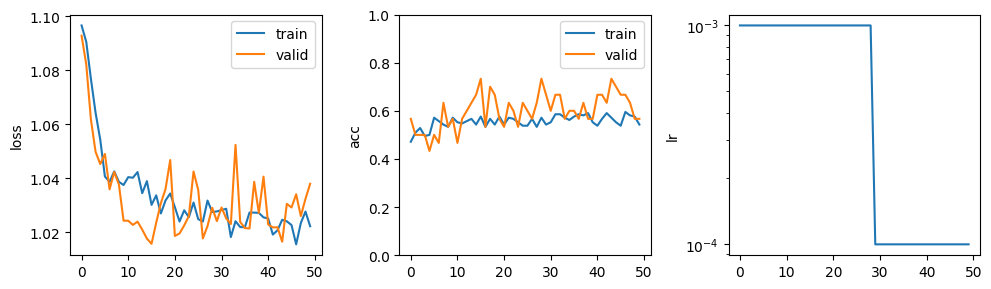

In [12]:
# plot history
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].plot(train_losses, label='train')
axs[0].plot(valid_losses, label='valid')
            
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(train_accuracies, label='train')
axs[1].plot(valid_accuracies, label='valid')
axs[1].set_ylabel('acc')
axs[1].set_ylim(0, 1)
axs[1].legend()
axs[2].plot(lrs)
axs[2].set_ylabel('lr')
axs[2].set_yscale('log')
plt.tight_layout()
plt.show()